In [14]:
# This file generates the data for Figure #4 from the paper https://arxiv.org/pdf/1806.06975.pdf

import os 
import pickle
import argparse
import networkx as nx
import pandas as pd
import numpy as np
import itertools
import sklearn
import torch
import datetime
from collections import Counter
import matplotlib, matplotlib.pyplot as plt
from torch.autograd import Variable

from models.model_wrapper import WrappedModel
from data import datasets
from data.graph_wrapper import GeneInteractionGraph

In [10]:
# Set the sample path depending on the location of your code and dataset.
# If it is unset, the TCGA dataset will be downloaded from Academic Torrents.
dataset = datasets.GeneDataset(file_path="/data/lisa/data/genomics/TCGA/TCGA_tissue_ppi.hdf5")
#dataset = datasets.GeneDataset(file_path="datastore/TCGA_tissue_ppi.hdf5")
#dataset = datasets.GeneDataset(at_hash="4070a45bc7dd69584f33e86ce193a2c903f0776d")

dataset.df = dataset.df - dataset.df.mean() # Make sure the dataset is normalized


Converting one-hot labels to integers


In [3]:
# On which graphs will we run this experiment? Parameterize this. 
# you will need to add your graph to AcademicTorrents and put the hash into the get_at_hash function in data/graph.py
# or simply pass the path directly into graph.load_graph() below.
graph_paths = {"regnet": "/data/lisa/data/genomics/graph/kegg.hdf5", "genemania": "/data/lisa/data/genomics/graph/pancan-tissue-graph.hdf5"}
graphs = {}

for graph_name in graph_paths.keys():
    #graph_path = GeneInteractionGraph.get_at_hash(graph_name) # otherwise use Academic Torrents to get the file
    graph_path = graph_paths[graph_name] # When on Mila Network
    
    gene_graph = GeneInteractionGraph(graph_path)
    mapping = dict(zip(range(0, len(dataset.df.columns)), dataset.df.columns))
    gene_graph.nx_graph = nx.relabel_nodes(gene_graph.nx_graph, mapping)
    graphs[graph_name] = gene_graph


In [4]:
# Setup the results dictionary
results_file_name = "experiments/results/fig-4.pkl"
try:
    results = pickle.load(open(results_file_name, "r"))
    print "Loaded Checkpointed Results"
except Exception as e:
    results = pd.DataFrame(columns=['auc', 'gene', 'model', 'graph', 'is_first_degree', 'seed', 'train_size'])
    print "Created a New Results Dictionary"


Loaded Checkpointed Results


In [5]:
def record_result(results, gene, model, graph_name, seed, train_size, auc, results_file_name, is_first_degree=None):
    experiment = {
        "gene": gene,
        "model": model.name,
        "graph": graph_name,
        "is_first_degree": is_first_degree,
        "seed": seed,
        "train_size": train_size,
        "auc": auc
    }

    results = results.append(experiment, ignore_index=True)
    results_dir = "/".join(results_file_name.split('/')[0:-1])

    if not os.path.isdir(results_dir):
        os.makedirs(results_dir)
    pickle.dump(results, open(results_file_name, "wb"))
    return results
    


In [6]:
train_size = 50
test_size = 1000
trials = 3
cuda = False
models = [WrappedModel(name="MLP", column_names=dataset.df.columns, dropout=False, cuda=cuda)]


In [12]:
# Create the set of all experiment ids and see which are left to do
model_names = [model.name for model in models]
columns = ["gene", "graph", "model", "seed", "is_first_degree", "train_size"]
all_exp_ids = [x for x in itertools.product(dataset.df.columns, graphs.keys(), model_names, range(trials), [True, False], [train_size])]
all_exp_ids = pd.DataFrame(all_exp_ids, columns=columns)
all_exp_ids.index = ["_".join(map(str, tup[1:-1])) for tup in all_exp_ids.itertuples(name=None)]
results_exp_ids = results[columns].copy()
results_exp_ids.index = ["_".join(map(str, tup[1:-1])) for tup in results_exp_ids.itertuples(name=None)]
intersection_ids = all_exp_ids.index.intersection(results_exp_ids.index)
todo = all_exp_ids.drop(intersection_ids)
print("todo: " + str(len(todo)))
print("done: " + str(len(results)))

todo: 194622
done: 3947


In [ ]:
for exp_id in todo.index:
    if len(results) % 10 == 0:
        print(len(results))
    gene, graph, model_name, seed, is_first_degree = exp_id.split("_")
    is_first_degree = bool(is_first_degree)
    seed = int(seed)
    model = [x for x in models if x.name == model_name][0]

    gene_expression_mean = dataset.df[gene].mean()
    dataset.labels = [1 if x > gene_expression_mean else 0 for x in dataset.df[gene]]
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(dataset.df, dataset.labels, stratify=dataset.labels, train_size=train_size, test_size=test_size)

    # record the failure to the results file and continue.
    if not (all([Counter(y_train).values() > 1]) and all([Counter(y_test).values() > 1]) and len(set(y_train)) > 1 and len(set(y_test)) > 1):
        results = record_result(results, gene, model, graph_name, int(seed), train_size, 0.5, results_file_name, is_first_degree)
        continue

    if is_first_degree:
        gene_graph = graphs[graph_name]
        neighbors = list(gene_graph.first_degree(gene)[0])
        X_train = X_train[neighbors].copy()
        X_test = X_test[neighbors].copy()
    else:
        X_train = X_train.copy()
        X_test = X_test.copy()
    X_train[gene] = 1
    X_test[gene] = 1
    try:

        model.fit(X_train, y_train)

        x_test = Variable(torch.FloatTensor(np.expand_dims(X_test.values, axis=2)), requires_grad=False).float()
        if cuda:
            x_test = x_test.cuda()
        y_hat = model.predict(x_test)[:, 1].data.cpu().numpy()
        auc = sklearn.metrics.roc_auc_score(y_test, np.asarray(y_hat).flatten())
        model.best_model = None # cleanup
    except Exception as e:
        import pdb; pdb.set_trace()
        pass
    results = record_result(results, gene, model, graph_name, seed, train_size, auc, results_file_name, is_first_degree)


9820
9830
9840
9850
9860
9870
9880
9890
9900
9910
9920
9930
9940
9950
9960
9970
9980
9990
10000
10010
10020
10030
10040
10050
10060
10070
10080
10090
10100
10110
10120
10130
10140
10150
10160
10170
10180
10190
10200
10210
10220
10230
10240
10250
10260
10270
10280
10290
10300
10310
10320
10330
10340
10350
10360
10370
10380
10390
10400
10410
10420
10430
10440
10450
10460
10470
10480
10490
10500
10510
10520
10530
10540
10550
10560
10570
10580
10590
10600
10610
10620
10630
10640
10650
10660
10670
10680
10690
10700
10710
10720
10730
10740
10750
10760
10770
10780
10790
10800
10810
10820
10830
10840
10850
10860
10870
10880
10890
10900
10910
10920
10930
10940
10950
10960
10970
10980
10990
11000
11010
11020
11030
11040
11050
11060
11070
11080
11090
11100
11110
11120
11130
11140
11150
11160
11170
11180
11190
11200
11210
11220
11230
11240
11250
11260
11270
11280
11290
11300
11310
11320
11330
11340
11350
11360
11370
11380
11390
11400
11410
11420
11430
11440
11450
11460
11470
11480
11490
11500
1151

In [15]:
# Compare the performance of each graph at predicting their neighbors
df = results

first_degree = df[df['is_first_degree'] == True][df['graph'] == 'genemania'].groupby(['gene', 'model', 'train_size'])['auc'].agg(['mean', 'std'])
full = df[df['is_first_degree'] == False][df['graph'] == 'genemania'].groupby(['gene','model', 'train_size'])['auc'].agg(['mean', 'std'])
genemania_df = first_degree.sub(full).sort_values('mean', ascending=False)

first_degree = df[df['is_first_degree'] == True][df['graph'] == 'regnet'].groupby(['gene', 'model', 'train_size'])['auc'].agg(['mean', 'std'])
full = df[df['is_first_degree'] == False][df['graph'] == 'regnet'].groupby(['gene','model', 'train_size'])['auc'].agg(['mean', 'std'])
regnet_df = first_degree.sub(full).sort_values('mean', ascending=False)


DataError: No numeric types to aggregate

/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/martinweiss/.pyenv/versions/2.7.13/lib/python2.7/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


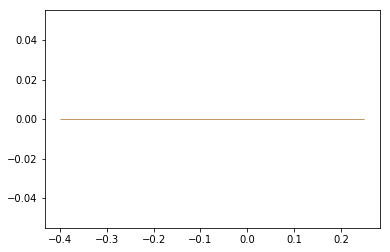

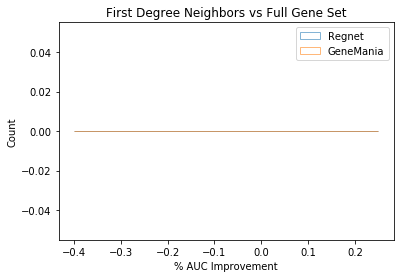

In [18]:

l1 = genemania_df['mean']
l2 = regnet_df['mean']

fig, ax = plt.subplots()
n1, bins1, patches1 = ax.hist(l1, range=(-.4, .25), bins=100, label="Regnet", density=0, alpha=0.55, histtype='step')
n1, bins1, patches1 = ax.hist(l2, range=(-.4, .25), bins=100, label="GeneMania", density=0, alpha=0.55, histtype='step')


fig, ax = plt.subplots()
n1, bins1, patches1 = ax.hist(l1, range=(-.4, .25), bins=100, label="Regnet", density=0, alpha=0.55, histtype='step')
n1, bins1, patches1 = ax.hist(l2, range=(-.4, .25), bins=100, label="GeneMania", density=0, alpha=0.55, histtype='step')

plt.title("First Degree Neighbors vs Full Gene Set")
plt.ylabel("Count")
plt.xlabel("% AUC Improvement")

plt.legend()
plt.show()

,auc,gene_name,model,graph,is_first_degree,seed,train_size
